In [1]:
import os # File system operations
import re # Regular expressions
import pandas as pd # Tabular data
import numpy as np # Numerical data
pd.set_option('display.max_colwidth', None) # Show full file paths
import sys

# Don't use all of the GPU RAM
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
from tensorflow.keras import mixed_precision
from tensorflow import keras # ML
import tensorflow_addons as tfa # TQDM progress bar when training
from sklearn.model_selection import train_test_split

BATCH_SIZE = 512

mixed_precision.set_global_policy('mixed_float16')


from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from pathlib import Path # Pathing
from glob import glob # Finding files recursively
import matplotlib.pyplot as plt # Plotting
import seaborn as sns # Plotting
sns.set()
from tqdm.auto import tqdm # Progress bars
tqdm.pandas()

BASE_DIR = Path("EmbryoLabeling/Labelers/train")
folders = os.listdir(BASE_DIR)
folders = [f for f in folders if not re.match(r"M\d", f)]
files = []
for folder in folders:
    files_in_folder = pd.DataFrame(glob(f"{BASE_DIR}/{folder}/**/*.jpg", recursive=True), columns=["filename"])
    files_in_folder["class"] = folder
    files.append(files_in_folder)
df = pd.concat(files)
df["class"].value_counts()

2022-05-30 22:48:58.941701: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-30 22:48:58.990737: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-30 22:48:58.990933: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla V100-PCIE-32GB, compute capability 7.0


2022-05-30 22:48:59.243360: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Empty                  5797
Morula                 1319
2pn                    1039
Syngamy                 834
4 Cell                  792
2 Cell                  736
Compacting 8 cell       549
Expanded Blastocyst     394
8 Cell                  384
Blastocyst              374
6 Cell                  360
Cavitating morula       324
3 Cell                  303
Early blast             291
5 Cell                  130
Name: class, dtype: int64

<AxesSubplot:>

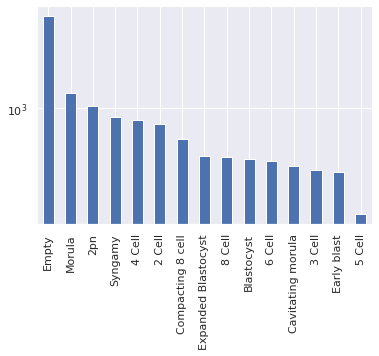

In [2]:
df["class"].value_counts().plot.bar(logy=True)

In [3]:
# Print counts of images by machine and slide
df.filename[~df["class"].isin(["bad", "Empty"])].apply(lambda s: s.split("/")[-1].split("_")[:2]).value_counts()

[M0776, S00512]    1952
[M776, S0087]      1559
[M0776, S00635]    1294
[M0776, S00761]    1138
[M0776, S00534]    1102
[M0776, S00470]     784
Name: filename, dtype: int64

In [4]:
# Track a single embryo's lifecycle
pd.set_option('display.max_rows', 365)
M776_S0087_W2 = df[df.filename.str.contains("M776_S0087_W2")].copy()
# Extract time since fertilisation in minutes from filename (ints, rounded to nearest minute)
M776_S0087_W2["time_since_fert"] = M776_S0087_W2.filename.apply(lambda s: s.replace(".jpg", "").split("_")[-1]).astype(int)
M776_S0087_W2 = M776_S0087_W2.sort_values(by="time_since_fert")
# Take the earliest time that each class was seen
M776_S0087_W2 = M776_S0087_W2.groupby("class").head(1)
print(M776_S0087_W2[["class", "time_since_fert"]])

                  class  time_since_fert
511                 2pn             1061
685             Syngamy             1464
298              2 Cell             1574
116              3 Cell             2315
104              4 Cell             2395
7                5 Cell             3045
29               6 Cell             3125
145              8 Cell             3265
24    Compacting 8 cell             3375
1169             Morula             4286
199   Cavitating morula             5940
50          Early blast             6090
113          Blastocyst             6261
4850              Empty             7036


In [5]:
classes = list(M776_S0087_W2["class"])
classes

['2pn',
 'Syngamy',
 '2 Cell',
 '3 Cell',
 '4 Cell',
 '5 Cell',
 '6 Cell',
 '8 Cell',
 'Compacting 8 cell',
 'Morula',
 'Cavitating morula',
 'Early blast',
 'Blastocyst',
 'Empty']

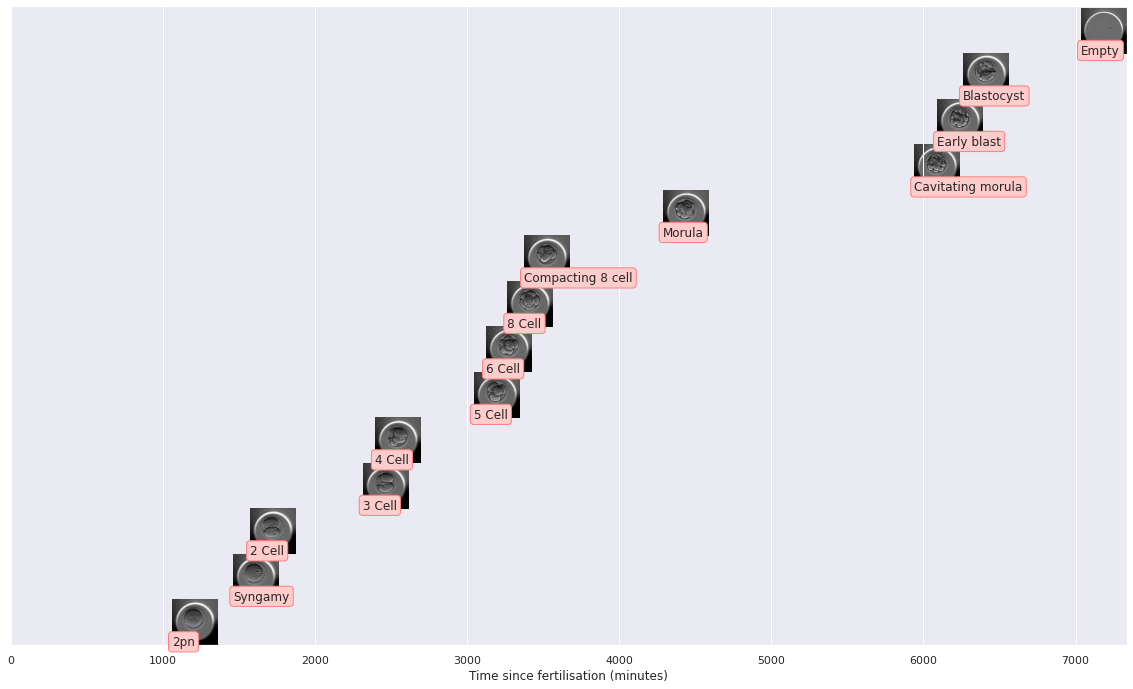

In [6]:
# Plot embryo's lifecycle over time
plt.figure(figsize=(20, 20))
for i, row in M776_S0087_W2.iterrows():
    image = keras.utils.load_img(row.filename, target_size=(299,299))
    c_index = classes.index(row["class"]) * 299
    time_since_fert = row.time_since_fert
    plt.imshow(image, extent=[time_since_fert, time_since_fert+299, c_index, c_index+299])
    plt.text(time_since_fert, c_index, row["class"], bbox=dict(boxstyle="round", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8)))
plt.yticks([])
plt.xlabel("Time since fertilisation (minutes)")
plt.xlim(0, M776_S0087_W2.time_since_fert.max() + 300)
plt.ylim(0, len(classes) * 300)
plt.show()

In [7]:
train = tf.keras.utils.image_dataset_from_directory(
    BASE_DIR,
    image_size = (299,299),
    batch_size = BATCH_SIZE,
    label_mode = 'categorical',
    shuffle = False
)

Found 13626 files belonging to 15 classes.


2022-05-30 22:49:01.328622: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-30 22:49:01.329526: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-30 22:49:01.329789: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-30 22:49:01.329919: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [8]:
classes = train.class_names
classes

['2 Cell',
 '2pn',
 '3 Cell',
 '4 Cell',
 '5 Cell',
 '6 Cell',
 '8 Cell',
 'Blastocyst',
 'Cavitating morula',
 'Compacting 8 cell',
 'Early blast',
 'Empty',
 'Expanded Blastocyst',
 'Morula',
 'Syngamy']

In [9]:
data_augmentation = keras.layers.RandomFlip("horizontal_and_vertical")
data_augmentation

In [10]:
train_aug = train.map(lambda x, y: (data_augmentation(x), y))

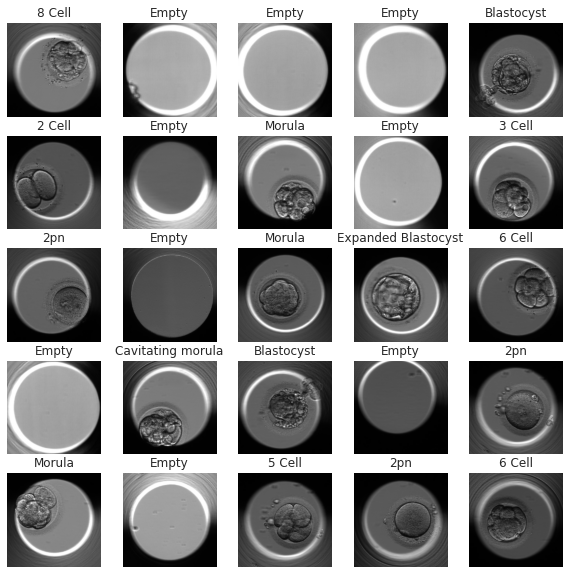

In [11]:
plt.figure(figsize=(10, 10))
for i, (idx, row) in enumerate(df.sample(25).iterrows()):
    ax = plt.subplot(5, 5, i + 1)
    image = keras.utils.load_img(row.filename, target_size=(299,299))
    plt.imshow(data_augmentation(image).numpy().astype("uint8"))
    plt.title(row["class"])
    plt.axis("off")

In [12]:
base_model = keras.Sequential([
    # Pre-trained Xception weights requires that input be scaled
    # from (0, 255) to a range of (-1., +1.), the rescaling layer
    # outputs: `(inputs * scale) + offset`
    keras.layers.Rescaling(scale=1./127.5, offset=-1, input_shape=(299,299,3)),
    keras.applications.Xception(
        weights='imagenet',  # Load weights pre-trained on ImageNet.
        include_top=False,
        pooling="avg"
    )
])
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 299, 299, 3)       0         
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
Total params: 20,861,480
Trainable params: 20,806,952
Non-trainable params: 54,528
_________________________________________________________________


In [13]:
extracted_features = base_model.predict(train_aug)

2022-05-30 22:49:08.593368: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
2022-05-30 22:49:09.409796: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


27/27 [==============================] - 30s 957ms/step


In [14]:
extracted_features.shape

(13626, 2048)

In [15]:
y = np.vstack([y for x,y in train])
y.shape

(13626, 15)

In [16]:
#x_train, x_test, y_train, y_test = train_test_split(extracted_features, y, test_size=.2)

# Use one slide for test, everything else for train
test_idx = pd.Series(train.file_paths).str.contains("M0776_S00512")
x_train = extracted_features[~test_idx]
y_train = y[~test_idx]
x_test = extracted_features[test_idx]
y_test = y[test_idx]
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((11339, 2048), (11339, 15), (2287, 2048), (2287, 15))

In [17]:
%%time
model = keras.Sequential([
    keras.layers.Input(shape=(2048)),
    keras.layers.Dense(len(classes), activation="softmax")
])
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()],
)
print(model.summary())
history = model.fit(x_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    validation_data=(x_test, y_test),
                    epochs=500,
                    verbose=0,
                    callbacks=[
                        keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy',patience=50, verbose=0),
                        tfa.callbacks.TQDMProgressBar()
                    ])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                30735     
                                                                 
Total params: 30,735
Trainable params: 30,735
Non-trainable params: 0
_________________________________________________________________
None


Training:   0%|           0/500 ETA: ?s,  ?epochs/s

Epoch 1/500


0/23           ETA: ?s - 

Epoch 2/500


0/23           ETA: ?s - 

Epoch 3/500


0/23           ETA: ?s - 

Epoch 4/500


0/23           ETA: ?s - 

Epoch 5/500


0/23           ETA: ?s - 

Epoch 6/500


0/23           ETA: ?s - 

Epoch 7/500


0/23           ETA: ?s - 

Epoch 8/500


0/23           ETA: ?s - 

Epoch 9/500


0/23           ETA: ?s - 

Epoch 10/500


0/23           ETA: ?s - 

Epoch 11/500


0/23           ETA: ?s - 

Epoch 12/500


0/23           ETA: ?s - 

Epoch 13/500


0/23           ETA: ?s - 

Epoch 14/500


0/23           ETA: ?s - 

Epoch 15/500


0/23           ETA: ?s - 

Epoch 16/500


0/23           ETA: ?s - 

Epoch 17/500


0/23           ETA: ?s - 

Epoch 18/500


0/23           ETA: ?s - 

Epoch 19/500


0/23           ETA: ?s - 

Epoch 20/500


0/23           ETA: ?s - 

Epoch 21/500


0/23           ETA: ?s - 

Epoch 22/500


0/23           ETA: ?s - 

Epoch 23/500


0/23           ETA: ?s - 

Epoch 24/500


0/23           ETA: ?s - 

Epoch 25/500


0/23           ETA: ?s - 

Epoch 26/500


0/23           ETA: ?s - 

Epoch 27/500


0/23           ETA: ?s - 

Epoch 28/500


0/23           ETA: ?s - 

Epoch 29/500


0/23           ETA: ?s - 

Epoch 30/500


0/23           ETA: ?s - 

Epoch 31/500


0/23           ETA: ?s - 

Epoch 32/500


0/23           ETA: ?s - 

Epoch 33/500


0/23           ETA: ?s - 

Epoch 34/500


0/23           ETA: ?s - 

Epoch 35/500


0/23           ETA: ?s - 

Epoch 36/500


0/23           ETA: ?s - 

Epoch 37/500


0/23           ETA: ?s - 

Epoch 38/500


0/23           ETA: ?s - 

Epoch 39/500


0/23           ETA: ?s - 

Epoch 40/500


0/23           ETA: ?s - 

Epoch 41/500


0/23           ETA: ?s - 

Epoch 42/500


0/23           ETA: ?s - 

Epoch 43/500


0/23           ETA: ?s - 

Epoch 44/500


0/23           ETA: ?s - 

Epoch 45/500


0/23           ETA: ?s - 

Epoch 46/500


0/23           ETA: ?s - 

Epoch 47/500


0/23           ETA: ?s - 

Epoch 48/500


0/23           ETA: ?s - 

Epoch 49/500


0/23           ETA: ?s - 

Epoch 50/500


0/23           ETA: ?s - 

Epoch 51/500


0/23           ETA: ?s - 

Epoch 52/500


0/23           ETA: ?s - 

Epoch 53/500


0/23           ETA: ?s - 

Epoch 54/500


0/23           ETA: ?s - 

Epoch 55/500


0/23           ETA: ?s - 

Epoch 56/500


0/23           ETA: ?s - 

Epoch 57/500


0/23           ETA: ?s - 

Epoch 58/500


0/23           ETA: ?s - 

Epoch 59/500


0/23           ETA: ?s - 

Epoch 60/500


0/23           ETA: ?s - 

Epoch 61/500


0/23           ETA: ?s - 

Epoch 62/500


0/23           ETA: ?s - 

Epoch 63/500


0/23           ETA: ?s - 

Epoch 64/500


0/23           ETA: ?s - 

Epoch 65/500


0/23           ETA: ?s - 

Epoch 66/500


0/23           ETA: ?s - 

Epoch 67/500


0/23           ETA: ?s - 

Epoch 68/500


0/23           ETA: ?s - 

Epoch 69/500


0/23           ETA: ?s - 

Epoch 70/500


0/23           ETA: ?s - 

Epoch 71/500


0/23           ETA: ?s - 

Epoch 72/500


0/23           ETA: ?s - 

Epoch 73/500


0/23           ETA: ?s - 

Epoch 74/500


0/23           ETA: ?s - 

Epoch 75/500


0/23           ETA: ?s - 

Epoch 76/500


0/23           ETA: ?s - 

Epoch 77/500


0/23           ETA: ?s - 

Epoch 78/500


0/23           ETA: ?s - 

Epoch 79/500


0/23           ETA: ?s - 

Epoch 80/500


0/23           ETA: ?s - 

Epoch 81/500


0/23           ETA: ?s - 

Epoch 82/500


0/23           ETA: ?s - 

Epoch 83/500


0/23           ETA: ?s - 

Epoch 84/500


0/23           ETA: ?s - 

Epoch 85/500


0/23           ETA: ?s - 

Epoch 86/500


0/23           ETA: ?s - 

Epoch 87/500


0/23           ETA: ?s - 

Epoch 88/500


0/23           ETA: ?s - 

Epoch 89/500


0/23           ETA: ?s - 

Epoch 90/500


0/23           ETA: ?s - 

Epoch 91/500


0/23           ETA: ?s - 

Epoch 92/500


0/23           ETA: ?s - 

Epoch 93/500


0/23           ETA: ?s - 

Epoch 94/500


0/23           ETA: ?s - 

Epoch 95/500


0/23           ETA: ?s - 

Epoch 96/500


0/23           ETA: ?s - 

Epoch 97/500


0/23           ETA: ?s - 

Epoch 98/500


0/23           ETA: ?s - 

Epoch 99/500


0/23           ETA: ?s - 

Epoch 100/500


0/23           ETA: ?s - 

Epoch 101/500


0/23           ETA: ?s - 

Epoch 102/500


0/23           ETA: ?s - 

Epoch 103/500


0/23           ETA: ?s - 

Epoch 104/500


0/23           ETA: ?s - 

Epoch 105/500


0/23           ETA: ?s - 

Epoch 106/500


0/23           ETA: ?s - 

Epoch 107/500


0/23           ETA: ?s - 

Epoch 108/500


0/23           ETA: ?s - 

Epoch 109/500


0/23           ETA: ?s - 

Epoch 110/500


0/23           ETA: ?s - 

Epoch 111/500


0/23           ETA: ?s - 

Epoch 112/500


0/23           ETA: ?s - 

Epoch 113/500


0/23           ETA: ?s - 

Epoch 114/500


0/23           ETA: ?s - 

Epoch 115/500


0/23           ETA: ?s - 

Epoch 116/500


0/23           ETA: ?s - 

Epoch 117/500


0/23           ETA: ?s - 

Epoch 118/500


0/23           ETA: ?s - 

Epoch 119/500


0/23           ETA: ?s - 

Epoch 120/500


0/23           ETA: ?s - 

Epoch 121/500


0/23           ETA: ?s - 

Epoch 122/500


0/23           ETA: ?s - 

Epoch 123/500


0/23           ETA: ?s - 

Epoch 124/500


0/23           ETA: ?s - 

Epoch 125/500


0/23           ETA: ?s - 

Epoch 126/500


0/23           ETA: ?s - 

Epoch 127/500


0/23           ETA: ?s - 

Epoch 128/500


0/23           ETA: ?s - 

Epoch 129/500


0/23           ETA: ?s - 

Epoch 130/500


0/23           ETA: ?s - 

Epoch 131/500


0/23           ETA: ?s - 

Epoch 132/500


0/23           ETA: ?s - 

Epoch 133/500


0/23           ETA: ?s - 

Epoch 134/500


0/23           ETA: ?s - 

Epoch 135/500


0/23           ETA: ?s - 

Epoch 136/500


0/23           ETA: ?s - 

Epoch 137/500


0/23           ETA: ?s - 

Epoch 138/500


0/23           ETA: ?s - 

Epoch 139/500


0/23           ETA: ?s - 

Epoch 140/500


0/23           ETA: ?s - 

Epoch 141/500


0/23           ETA: ?s - 

Epoch 142/500


0/23           ETA: ?s - 

Epoch 143/500


0/23           ETA: ?s - 

Epoch 144/500


0/23           ETA: ?s - 

Epoch 145/500


0/23           ETA: ?s - 

Epoch 146/500


0/23           ETA: ?s - 

Epoch 147/500


0/23           ETA: ?s - 

Epoch 148/500


0/23           ETA: ?s - 

CPU times: user 41.5 s, sys: 5.89 s, total: 47.4 s
Wall time: 30 s


<AxesSubplot:>

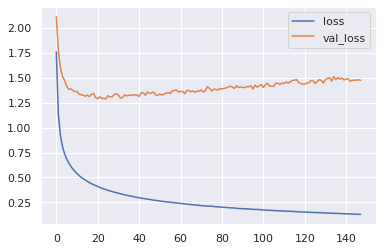

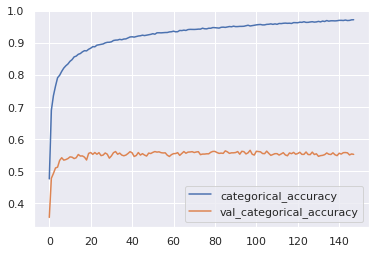

In [18]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['categorical_accuracy', 'val_categorical_accuracy']].plot()

In [19]:
y_pred = model.predict(x_test)

72/72 [==============================] - 0s 1ms/step


In [20]:
predicted_codes = y_pred.argmax(axis=1)
confidence = y_pred.max(axis=1)
pd.Series(confidence).describe()

count    2287.000000
mean        0.736328
std         0.223145
min         0.196533
25%         0.543457
50%         0.767578
75%         0.962158
max         1.000000
dtype: float64

In [21]:
true_classes = [classes[c] for c in y_test.argmax(axis=1)]
pd.Series(true_classes).value_counts()

Empty                  335
2pn                    297
Morula                 291
Syngamy                244
4 Cell                 163
2 Cell                 152
8 Cell                 131
Compacting 8 cell      119
Early blast             91
Cavitating morula       89
Expanded Blastocyst     89
Blastocyst              87
6 Cell                  78
3 Cell                  65
5 Cell                  56
dtype: int64

In [22]:
validation_df = pd.DataFrame()
validation_df["true_class"] = true_classes
validation_df["predicted_class"] = [classes[c] for c in predicted_codes]
validation_df["confidence"] = confidence
validation_df

,true_class,predicted_class,confidence
0,2 Cell,4 Cell,0.893066
1,2 Cell,4 Cell,0.814453
2,2 Cell,4 Cell,0.755859
3,2 Cell,4 Cell,0.680664
4,2 Cell,4 Cell,0.648926
...,...,...,...
2282,Syngamy,Syngamy,0.757812
2283,Syngamy,2 Cell,0.729980
2284,Syngamy,Syngamy,0.741699
2285,Syngamy,Syngamy,0.555664


In [23]:
validation_df.groupby("predicted_class").confidence.median()

predicted_class
2 Cell                 0.589844
2pn                    0.799316
3 Cell                 0.412109
4 Cell                 0.752441
5 Cell                 0.487061
6 Cell                 0.510742
8 Cell                 0.543945
Blastocyst             0.657227
Cavitating morula      0.571777
Compacting 8 cell      0.553223
Early blast            0.635742
Empty                  0.999512
Expanded Blastocyst    0.945801
Morula                 0.774414
Syngamy                0.783203
Name: confidence, dtype: float16

In [24]:
validation_df.to_csv("validation_predictions.csv", index=False)

                     precision    recall  f1-score   support

             2 Cell       0.36      0.53      0.43       152
                2pn       0.78      0.62      0.69       297
             3 Cell       0.03      0.02      0.02        65
             4 Cell       0.38      0.36      0.37       163
             5 Cell       0.05      0.02      0.03        56
             6 Cell       0.13      0.13      0.13        78
             8 Cell       0.52      0.12      0.20       131
         Blastocyst       0.45      0.30      0.36        87
  Cavitating morula       0.35      0.33      0.34        89
  Compacting 8 cell       0.21      0.24      0.22       119
        Early blast       0.56      0.49      0.53        91
              Empty       1.00      1.00      1.00       335
Expanded Blastocyst       0.59      0.85      0.70        89
             Morula       0.46      0.73      0.56       291
            Syngamy       0.69      0.66      0.67       244

           accuracy   

Text(30.499999999999993, 0.5, 'True')

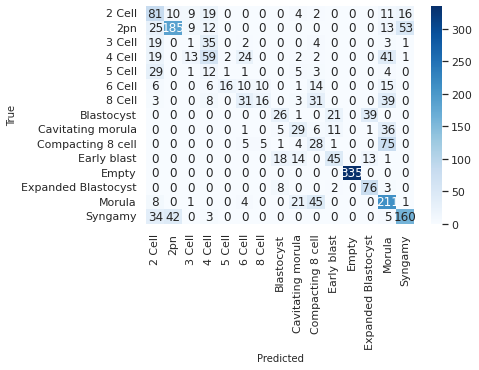

In [25]:
print(classification_report(validation_df["true_class"], validation_df["predicted_class"]))
s = sns.heatmap(
    confusion_matrix(validation_df["true_class"], validation_df["predicted_class"]),
    annot=True,
    cmap='Blues',
    fmt="g",
    xticklabels=classes,
    yticklabels=classes
)
s.set_xlabel('Predicted', fontsize=10)
s.set_ylabel('True', fontsize=10)

In [26]:
model.save(f"models/{len(classes)}_class.h5")

In [27]:
test = tf.keras.utils.image_dataset_from_directory(
    "EmbryoLabeling/Labelers/One/M3169_S00470",
    labels=None,
    image_size = (299,299),
    batch_size = BATCH_SIZE,
    shuffle = False
)

Found 3591 files belonging to 1 classes.


In [28]:
extracted_features_test = base_model.predict(test)
results = model.predict(extracted_features_test)

113/113 [==============================] - 0s 2ms/step


In [29]:
predicted_codes = results.argmax(axis=1)
confidence = results.max(axis=1)
pd.Series(confidence).describe()

count    3591.000000
mean        0.665039
std         0.196655
min         0.216187
25%         0.501221
50%         0.657227
75%         0.835205
max         0.999512
dtype: float64

In [30]:
test_df = pd.DataFrame()
test_df["filepath"] = test.file_paths
test_df["class"] = [classes[c] for c in predicted_codes]
test_df["confidence"] = confidence
test_df

,filepath,class,confidence
0,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W1_F0_1010.jpg,2pn,0.985840
1,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W1_F0_1031.jpg,2pn,0.995605
2,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W1_F0_1052.jpg,2pn,0.995605
3,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W1_F0_1073.jpg,2pn,0.996094
4,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W1_F0_1094.jpg,2pn,0.993164
...,...,...,...
3586,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W9_F0_990.jpg,Syngamy,0.696289
3587,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W9_F0_9921.jpg,Empty,0.808594
3588,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W9_F0_9942.jpg,Empty,0.708984
3589,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W9_F0_9963.jpg,Empty,0.590332


In [31]:
test_df["class"].value_counts()

2pn                    1244
Morula                  850
Empty                   483
Syngamy                 335
Blastocyst              244
5 Cell                  178
Expanded Blastocyst     165
Early blast              52
2 Cell                   29
4 Cell                    7
Cavitating morula         3
Compacting 8 cell         1
Name: class, dtype: int64

In [32]:
test_df

,filepath,class,confidence
0,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W1_F0_1010.jpg,2pn,0.985840
1,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W1_F0_1031.jpg,2pn,0.995605
2,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W1_F0_1052.jpg,2pn,0.995605
3,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W1_F0_1073.jpg,2pn,0.996094
4,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W1_F0_1094.jpg,2pn,0.993164
...,...,...,...
3586,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W9_F0_990.jpg,Syngamy,0.696289
3587,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W9_F0_9921.jpg,Empty,0.808594
3588,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W9_F0_9942.jpg,Empty,0.708984
3589,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W9_F0_9963.jpg,Empty,0.590332


In [33]:
test_df.to_csv("predictions.csv", index=False)